# Notebook to demonstrate how to select isovalues with ROMS model output 
Relies on ```xroms.isoslice()```

In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-92.5)

/d2/home/dylan/.conda/envs/txla_model/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
paths = 'https://hafen.geos.tamu.edu/thredds/dodsC/NcML/txla_nest_p_avg_2021_v2_agg'

def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    return ds1, grid1

ds, grid = open_roms(paths)

In [3]:
xroms.isoslice?

Signature: xroms.isoslice(var, iso_values, xgrid, iso_array=None, axis='Z')
Docstring:
Interpolate var to iso_values.

This wraps `xgcm` `transform` function for slice interpolation,
though `transform` has additional functionality.

Parameters
----------
var: DataArray
    Variable to operate on.
iso_values: list, ndarray
    Values to interpolate to. If calculating var at fixed depths,
    iso_values are the fixed depths, which should be negative if
    below mean sea level. If input as array, should be 1D.
xgrid: xgcm.grid, optional
    Grid object associated with var.
iso_array: DataArray, optional
    Array that var is interpolated onto (e.g., z coordinates or
    density). If calculating var on fixed depth slices, iso_array
    contains the depths [m] associated with var. In that case and
    if None, will use z coordinate attached to var. Also use this
    option if you want to interpolate with z depths constant in
    time and input the appropriate z coordinate.
dim: str, option

### Slice potential temperature at depths of $z=[-30,0]$ in steps of 3

In [4]:
temp_iso = xroms.isoslice(ds.temp, np.arange(-30, 3, 3), grid, axis = 'Z')
temp_iso

/d2/home/dylan/.conda/envs/txla_model/lib/python3.11/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


<xarray.DataArray 'temp' (ocean_time: 720, z_rho: 11, eta_rho: 191, xi_rho: 671)>
dask.array<transpose, shape=(720, 11, 191, 671), dtype=float32, chunksize=(1, 11, 191, 671), chunktype=numpy.ndarray>
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2021-06-11T00:30:00 ... 2021-07-1...
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 664 665 666 667 668 669 670
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 184 185 186 187 188 189 190
  * z_rho       (z_rho) int64 -30 -27 -24 -21 -18 -15 -12 -9 -6 -3 0
Attributes:
    long_name:    time-averaged potential temperature
    units:        Celsius
    time:         ocean_time
    grid:         grid
    location:     face
    field:        temperature, scalar, series
    _ChunkSizes:  [  1  15  96 336]

### Plot the values at the nearest available isoslice
Using the ```method='nearest'``` argument to ```.sel()``` will do exactly as it sounds. This is super useful, especially for lateral slices where lat/lon are not exactly aligned with the grid 

In [5]:
lat_rad = 1.0/np.cos(np.radians(ds.lat_rho.mean().values))
t = temp_iso.sel(ocean_time = '2010-06-11 01:30',z_rho = -3, method = 'nearest').compute()
t1 = temp_iso.sel(ocean_time = '2010-06-11 01:30',z_rho = -10, method = 'nearest').compute()

/d2/home/dylan/.conda/envs/txla_model/lib/python3.11/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


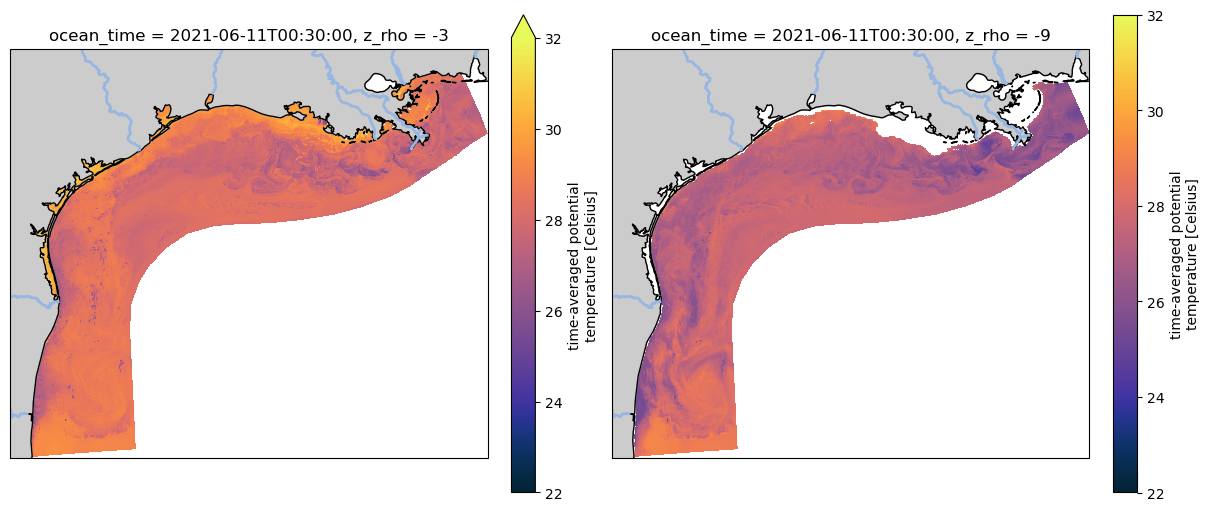

In [6]:
fig, ax = plt.subplots(1,2, figsize = (12,5), subplot_kw={'projection': crs}, constrained_layout = True)

t.plot(ax = ax[0], x = 'lon_rho', y = 'lat_rho', cmap = cmo.thermal, vmin = 22, vmax = 32, transform=ccrs.PlateCarree())
t1.plot(ax = ax[1], x = 'lon_rho', y = 'lat_rho', cmap = cmo.thermal, vmin = 22, vmax = 32, transform=ccrs.PlateCarree())
for i in range(2):
    ax[i].add_feature(land_10m, facecolor='0.8', linewidth = 1) # add land
    ax[i].coastlines(resolution='10m', linewidth = 1)  # add coastlines 
    ax[i].set_aspect(lat_rad) # set aspect ratio
    ax[i].add_feature(cartopy.feature.RIVERS, lw = 2) # add rivers

### We see that ```isoslice()``` is functioning as intended.
Temperature decreases with depth, values close to the coast at shallower depths are masked automatically.